In [15]:
from __future__ import absolute_import, division, print_function

import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

import base64
import imageio
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import tensorflow as tf
import IPython

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [3]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
tf.version.VERSION

'2.15.1'

In [5]:
num_iterations = 20000

initial_collect_steps = 100
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

In [8]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco

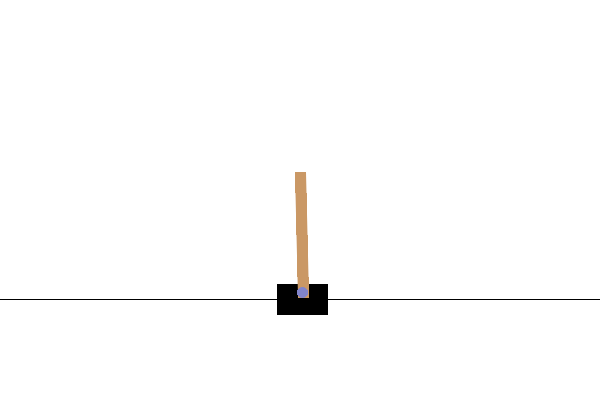

In [9]:
#print(train_env.time_step_spec().observation)
#print(train_env.time_step_spec().discount)
#print(train_env.action_spec())
#print(train_env.reset())
#train_env.render('human')
env.reset()
render = env.render()
PIL.Image.fromarray(render)

#FAIL KERNEL CRASHED

In [16]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'
            )
        )

dense_layers = [ dense_layer(num_units) for num_units in fc_layer_params ]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03
    ),
    bias_initializer=tf.keras.initializers.Constant(-0.2)
)
q_net = sequential.Sequential(dense_layers + [q_values_layer])

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))


In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)
agent.initialize()
q_net.summary()

tf.keras.utils.plot_model(q_net, to_file='agent.png', show_shapes=True, show_layer_names=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             multiple                  500       
                                                                 
 dense_4 (Dense)             multiple                  5050      
                                                                 
 dense_5 (Dense)             multiple                  102       
                                                                 
Total params: 5652 (22.08 KB)
Trainable params: 5652 (22.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [12]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(
    train_env.time_step_spec(), 
    train_env.action_spec()
)

In [24]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0

    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
                    
        total_return += episode_return
    
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [25]:
compute_avg_return(train_env, random_policy)

23.4

In [27]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature
)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server
)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmp40hv4rlj.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmp/tmp40hv4rlj
[reverb/cc/platform/default/server.cc:71] Started replay server on port 42303


In [68]:
#replay_buffer.clear()
#reverb_server.stop()

In [28]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2
)

In [32]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [31]:
iterator = iter(dataset)

In [33]:
agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True
    ),
    [rb_observer],
    max_steps=collect_steps_per_iteration
)

for _ in range(num_iterations):
    time_step, _ = collect_driver.run(time_step)

    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step == 1 or step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step == 1 or step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        returns.append(avg_return)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        print('-----------------------------------------------------------')

[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (69572) so Table uniform_table is accessed directly without gRPC.


step = 1: loss = 1.0577337741851807
step = 1: Average Return = 14.300000190734863
-----------------------------------------------------------
step = 200: loss = 23.887069702148438
step = 400: loss = 7.109371662139893
step = 600: loss = 89.29505157470703
step = 800: loss = 174.39361572265625
step = 1000: loss = 518.8209228515625
step = 1000: Average Return = 97.80000305175781
-----------------------------------------------------------
step = 1200: loss = 21642.3671875
step = 1400: loss = 87355.21875
step = 1600: loss = 98724.75
step = 1800: loss = 173645.34375
step = 2000: loss = 1872965.375
step = 2000: Average Return = 200.0
-----------------------------------------------------------
step = 2200: loss = 478649.3125
step = 2400: loss = 1935765.25
step = 2600: loss = 212672448.0
step = 2800: loss = 3744947.75
step = 3000: loss = 3319857.75
step = 3000: Average Return = 200.0
-----------------------------------------------------------
step = 3200: loss = 7643331.0
step = 3400: loss = 596

(5.015000200271606, 250.0)

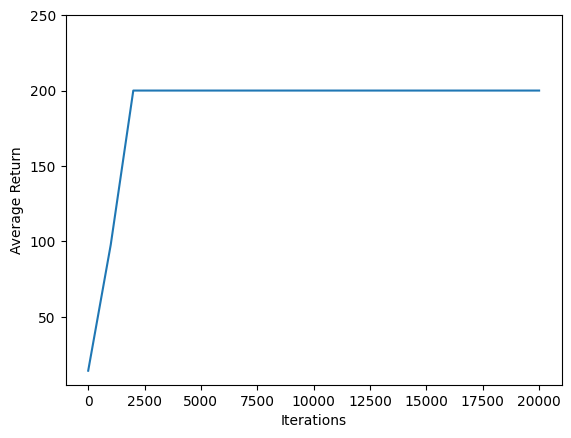

In [39]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns[1:])
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

In [40]:
def embed_mp4(filename):
    video = open(filename, 'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
        <video width="640" height="480" controls>
            <source src="data:video/mp4;base64,{0}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    '''.format(b64.decode())

    return IPython.display.HTML(tag)

In [41]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + '.mp4'

    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = eval_env.reset()
            video.append_data(eval_py_env.render())

            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = eval_env.step(action_step.action)
                video.append_data(eval_py_env.render())
    
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a recognized feature for this target (ignoring feature)
'-avx512er' is not a recognized feature for this target (ignoring feature)
'-avx512pf' is not a reco